# Prerequisites

In [1]:
!pip freeze

absl-py==1.4.0
-e git+https://github.com/geronimi73/accelerate@d25a787628e42ef9efcc165807ba7aa9fa9d56ae#egg=accelerate
addict==2.4.0
aenum==3.1.15
aiodns==3.1.1
aiofiles==23.1.0
aiohttp==3.9.2
aiohttp-retry==2.8.3
aiosignal==1.3.1
altair==5.1.1
annotated-types==0.6.0
antlr4-python3-runtime==4.9.3
anyio==3.7.1
apache-beam==2.52.0
appdirs==1.4.4
apturl==0.5.2
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
astunparse==1.6.3
async-lru==2.0.4
async-timeout==4.0.3
attributedict==0.3.0
attrs==23.1.0
autoawq==0.1.8
Babel==2.13.1
backoff==2.2.1
basicsr==1.4.2
bcrypt==3.2.0
beautifulsoup4==4.10.0
beniget==0.4.1
bitsandbytes==0.42.0
black==23.12.1
bleach==6.1.0
blendmodes==2022
blessings==1.7
blinker==1.4
boltons==23.0.0
boto3==1.34.34
botocore==1.34.34
bottle==0.12.19
Brlapi==0.8.3
Brotli==1.1.0
cached-property==1.5.2
cachetools==5.3.2
cattrs==23.2.3
causal-conv1d==1.0.0
certifi==2023.11.17
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.2.0
ci-info==0.3.0
clean

# 1 Simple example: similarity of single words
embedd a few simple words different meanings

## load embedding model

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')

/home/g/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


## embedd samples

In [3]:
# code taken from model card of sentence-transformers/all-mpnet-base-v2

# Sentences we want sentence embeddings for
sentences = ["lemon", "orange", "car", "money"]

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)

Sentence embeddings:
tensor([[ 0.0398, -0.0315, -0.0107,  ...,  0.0002, -0.0352, -0.0136],
        [ 0.0116,  0.0079,  0.0351,  ...,  0.0365, -0.0294,  0.0150],
        [-0.0155,  0.0116,  0.0246,  ..., -0.0148, -0.0448, -0.0136],
        [ 0.0272,  0.0794,  0.0010,  ...,  0.0121,  0.0031, -0.0031]])


In [4]:
sentence_embeddings.shape

torch.Size([4, 768])

## calculate similarity 

In [5]:
for i in range(0, len(sentences)):
    print(
        sentences[0],
        sentences[i],
        (sentence_embeddings[0]@sentence_embeddings[i]).item()
    )    

lemon lemon 1.0
lemon orange 0.5340331792831421
lemon car 0.29094186425209045
lemon money 0.2281380295753479


## PCA and plot in 2d-space

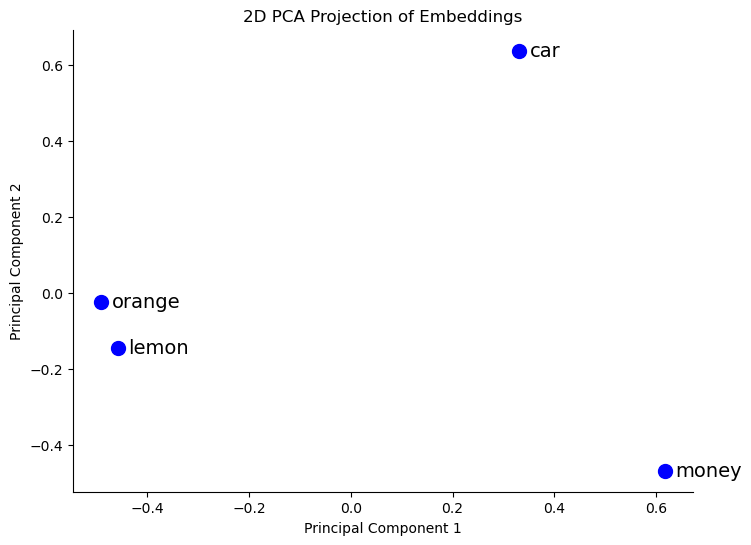

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize PCA, reducing to 2 dimensions
pca = PCA(n_components=2)

# Fit and transform the embeddings
embeddings_2d = pca.fit_transform(sentence_embeddings)

# Plotting with labels for each data point
plt.figure(figsize=(8, 6))
for i, point in enumerate(embeddings_2d):
    plt.scatter(point[0], point[1], c='blue', edgecolor=None, s=100)
    plt.text(point[0] + 0.02, point[1] - 0.014, sentences[i], fontsize=14)

plt.title("2D PCA Projection of Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.gca().spines['top'].set_visible(False)    # Hide top border
plt.gca().spines['right'].set_visible(False)    # Hide top border

plt.show()

# 2 Advanced example: embedd questions from public dataset
embedd all questions from Open Assistant 2 dataset (g-ronimo/oasst2_top1_en) and find most similar and dissimilar ones

## load dataset, extract first question

In [7]:
from datasets import load_dataset

dataset = load_dataset("g-ronimo/oasst2_top1_en")
questions = [ d["conversation"][0]["content"] for d in dataset["train"]]
len(questions)

5419

## embedd

In [8]:
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import torch, gc
import torch.nn as nn

class EmbeddingModelWrapper():
    def __init__(self, model_path="sentence-transformers/all-mpnet-base-v2", bs=8):
        self.model, self.tokenizer = self.load_model(model_path)
        self.bs = bs
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)

    def load_model(self, model_path):
        model = AutoModel.from_pretrained(model_path).cuda()
        model.eval()
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        return model, tokenizer

    def emb_mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0] 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def get_embeddings(self, sentences):
        embeddings = torch.tensor([],device="cuda")
        
        if self.bs is None:
            batches = [sentences]
        else:
            batches = [sentences[i:i + self.bs] for i in range(0, len(sentences), self.bs)]  
            
        for sentences in batches:
            encoded_input = self.tokenizer(sentences, padding=True, truncation=True, return_tensors='pt').to("cuda")
            with torch.no_grad():
                model_output = self.model(**encoded_input)        
            batch_embeddings=self.emb_mean_pooling(model_output, encoded_input['attention_mask'])
            embeddings=torch.cat( (embeddings, batch_embeddings), dim=0 )

        return embeddings

    def get_similarities(self, x, y=None):
        if y is None:
            num_samples=x.shape[0]
            similarities = [[0 for i in range(num_samples)] for f in range(num_samples)]
            for row in tqdm(range(num_samples)):
                similarities[row][0:row+1]=em.cos(x[row].repeat(row+1,1), x[0:row+1]).tolist()
            return similarities
        else:            
            return self.cos(x,y).tolist()

In [9]:
em = EmbeddingModelWrapper()

In [10]:
sentence_embeddings = em.get_embeddings(questions)

KeyboardInterrupt: 

## plot PCA projection for all question embeddings

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize PCA, reducing to 2 dimensions
pca = PCA(n_components=2)

# Fit and transform the embeddings
embeddings_2d = pca.fit_transform(sentence_embeddings)

# Plotting with labels for each data point
plt.figure(figsize=(8, 6))
for i, point in enumerate(embeddings_2d):
    plt.scatter(point[0], point[1], c='blue', edgecolor='k', s=100)
    # plt.text(point[0] + 0.02, point[1] - 0.01, sentences[i], fontsize=12)

plt.title("2D PCA Projection of Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

## find most similar and dissimilar questions

In [ ]:
similarities = em.get_similarities(sentence_embeddings)

In [ ]:
minSim, maxSim = 1, -1
minSimElement, maxSimElement = [], []

for row in range(len(questions)):
    for col in range(0, row):
        if questions[row].replace(" ","").lower() == questions[col].replace(" ", "").lower(): continue
        sim = similarities[row][col]
        if sim > maxSim:
            maxSim = sim
            maxSimElement = [row, col]
        elif sim < minSim:
            minSim = sim
            minSimElement = [row, col]
display([maxSim, maxSimElement])
display([minSim, minSimElement])

In [ ]:
display(questions[maxSimElement[0]], questions[maxSimElement[1]])
print()
display(questions[minSimElement[0]], questions[minSimElement[1]])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize PCA, reducing to 2 dimensions
pca = PCA(n_components=2)

# Fit and transform the embeddings
embeddings_2d = pca.fit_transform(sentence_embeddings.cpu())

# Plotting with labels for each data point
plt.figure(figsize=(8, 6))
for i, point in enumerate(embeddings_2d):
    col="grey"
    alpha=0.1
    
    if i in maxSimElement:
        col="green"
        alpha=1
    elif i in minSimElement:
        col="red"
        alpha=1
    
    plt.scatter(point[0], point[1], c=col, alpha=alpha, edgecolor='black', s=100)
    # plt.text(point[0] + 0.02, point[1] - 0.01, sentences[i], fontsize=12)

plt.title("2D PCA Projection of Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()